# Loading data

In [1]:
import tensorflow as tf
train,test = tf.keras.datasets.mnist.load_data(path="mnist.npz")
import numpy as np

import numpy as np

X_test = test[0]
X_test = X_test.reshape((10000,28,28,1))
import numpy as np
def to_one_hot(y, num_class=10):
  master = []
  for value in y:
    row = np.zeros(num_class)
    row[value] = 1
    master.append(row)
  return np.array(master)

y_test = to_one_hot(test[1], num_class =10)
X_test = X_test.astype("float32")

X_test_flat = test[0].reshape((10000,784))
y_test = to_one_hot(test[1], num_class =10)
X_test_flat = X_test_flat.astype("float32")

Models (we will not train them, but instead, use weights we got from our training notebooks)

In [2]:
classifier = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/Dense_arch.h5")
classifier.load_weights("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/Dense.h5")

noisy_classifier = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/Dense_arch.h5")
noisy_classifier.load_weights("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/DenseNoisy3.h5")

ResNet = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/RN_arch.h5")
ResNet.load_weights("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/RNN.h5")

noisy_ResNet = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/RN_arch.h5")
noisy_ResNet.load_weights("/content/drive/MyDrive/Trick_NN/Models/MNIST_Models/RNN_Noisy3.h5")

In [3]:
cands = [0,103, 1443, 173,7229,3,89,7819,9829,2000]
labs = ["7", "4", "8", "3", "2", "0", "1", "5", "9", "6"]
labels_mapping = ["7", "4", "8", "3", "2", "0", "1", "5", "9", "6"]

# Attacking

In [65]:
from copy import deepcopy
langs = list(range(0,10))
models = [classifier, noisy_classifier, ResNet, noisy_ResNet]

models_master_hist = []

for cnt10, model in enumerate(models):
  print("New Model")
  master_hist = []
  for i in cands:
    print(i)
    digit = X_test[i]
    label = test[1][i]
    y_true = np.zeros((1, 10))
    y_true[0, label] = 1
    digit = digit.astype("float32")
    #untargeted
    import numpy
    import keras
    digit2 = digit.reshape((1,28,28,1)).copy()
    true_target = y_true.copy()

    if cnt10 < 2:
      lr = 1
    else:
      lr = 1

    decay = 0.0005

    hist = [digit2]
    histp = [model.predict(digit2)]
    rcnt = 0
    for t in range(1000):
      # gradient descent
      fake_img2 = digit2.reshape((1,28,28,1)).copy() # initialize
      fake_img = tf.Variable(fake_img2)

      with tf.GradientTape() as tape:
        tape.watch(fake_img)

        pred = model(fake_img)
        loss = keras.metrics.binary_crossentropy(pred, true_target)
        #print(loss)


      grad = tape.gradient(loss, fake_img)
      #g = tf.sign(grad).numpy()
      g = (grad / np.max(numpy.abs(grad))).numpy()
      g[g==0] = np.random.rand()
      g = np.nan_to_num(g, copy=True, nan = 1)
      #print(type(g))
      digits3 = digit2 + lr*g
      np.argmax(digits3)
      digit2 = digits3
      digit2[digit2 < 0] = 0
      digit2[digit2 > 255] = 255
      hist.append(digit2)
      histp.append(model.predict(digit2))
      #print(pred)

      lr = lr/(lr + decay*t)
      #print(lr)

      if np.argmax(pred.numpy()) != np.argmax(true_target) and np.max(pred.numpy()) > 0.9:
        print("Achieved at", t, loss.numpy())
        break
      if np.max(pred.numpy()) == np.max(model.predict(255*np.random.rand(1,28,28,1))):
        rcnt += 1
      else:
        rcnt = 0
      
      if rcnt > 20:
        print("Achieved Random State at", t, loss.numpy())
        break

    master_hist.append([deepcopy(hist), deepcopy(histp)])
  models_master_hist.append(master_hist)
#plt.show()

New Model
0
Achieved at 81 [3.08278986]
103
Achieved at 116 [3.08186545]
1443
Achieved at 25 [2.87190576]
173
Achieved at 11 [3.07963498]
7229
Achieved at 161 [3.08490599]
3
Achieved at 175 [3.08498969]
89
Achieved at 39 [3.084985]
7819
Achieved at 148 [3.08498977]
9829
Achieved at 58 [3.08488478]
2000
Achieved at 47 [3.07614668]
New Model
0
Achieved Random State at 60 [2.96109645]
103
Achieved Random State at 71 [2.86967171]
1443
Achieved Random State at 30 [1.89716141]
173
Achieved Random State at 470 [2.70365487]
7229
Achieved Random State at 36 [2.78198658]
3
Achieved Random State at 43 [2.95133769]
89
Achieved Random State at 43 [3.05247712]
7819
Achieved Random State at 48 [2.83017619]
9829
Achieved Random State at 23 [2.76580169]
2000
Achieved Random State at 45 [2.95154291]
New Model
0
Achieved at 178 [2.80299544]
103
Achieved at 324 [2.80007931]
1443
Achieved at 249 [2.84646887]
173
Achieved at 101 [2.7965152]
7229
Achieved at 87 [2.8292948]
3
Achieved at 269 [3.08388271]
89
A

In [ ]:
import pickle

with open("/content/drive/MyDrive/Trick_NN/Media/5model.pkl", "wb") as fp:   #Pickling
  pickle.dump(models_master_hist, fp)

In [66]:
imgs = []

for cnt in range(10):
  ims = [x[cnt][0][-1] for x in  models_master_hist]
  ims.append(models_master_hist[0][cnt][0][0])
  imgs.append(ims)

labs = []
for cnt in range(10):
  lab = [np.argmax(x[cnt][1][-1]) for x in  models_master_hist]
  lab.append(np.argmax(models_master_hist[0][cnt][1][0]))
  labs.append(lab)

In [67]:
labs

[[3, 8, 3, 3, 7],
 [8, 8, 2, 3, 4],
 [3, 8, 3, 3, 8],
 [0, 8, 5, 5, 3],
 [9, 8, 3, 3, 2],
 [3, 8, 7, 6, 0],
 [2, 8, 7, 4, 1],
 [2, 8, 0, 8, 5],
 [8, 8, 4, 4, 9],
 [8, 8, 5, 5, 6]]

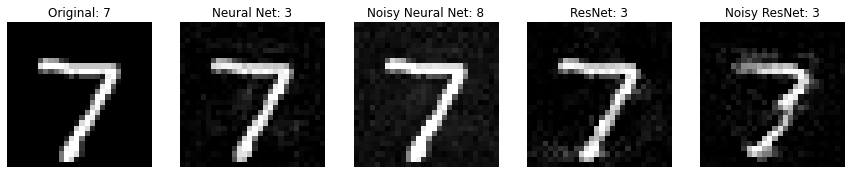

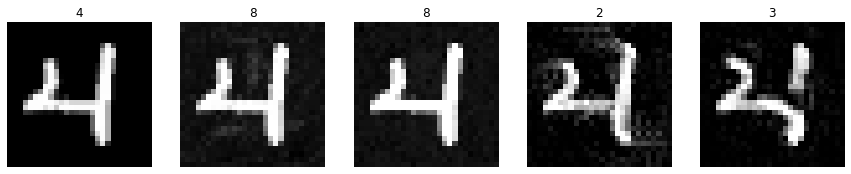

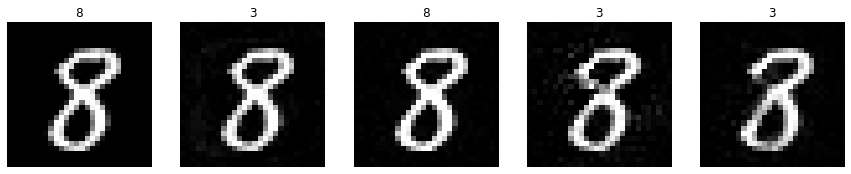

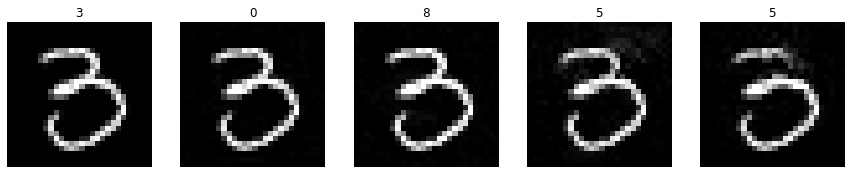

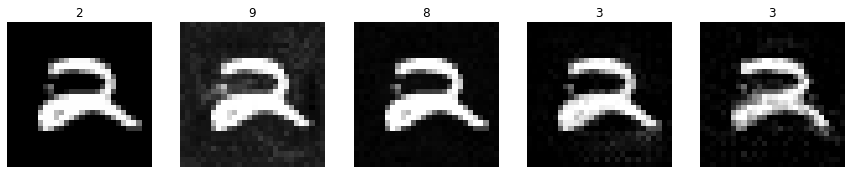

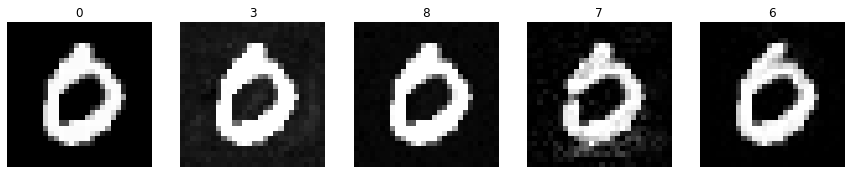

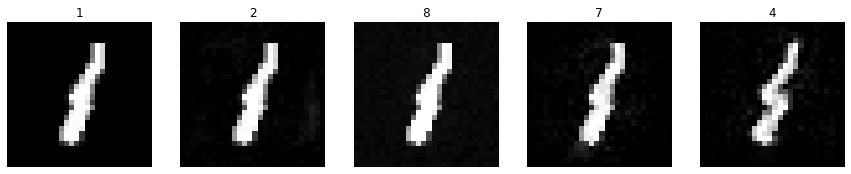

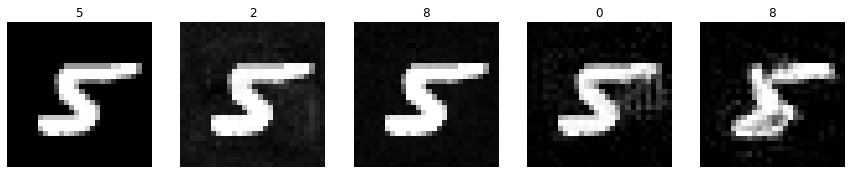

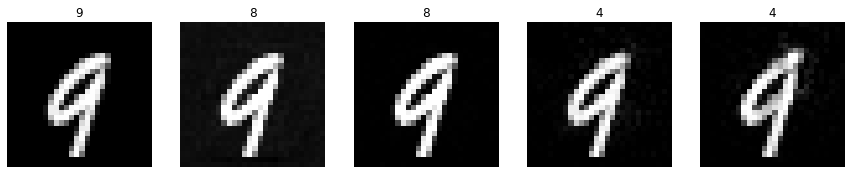

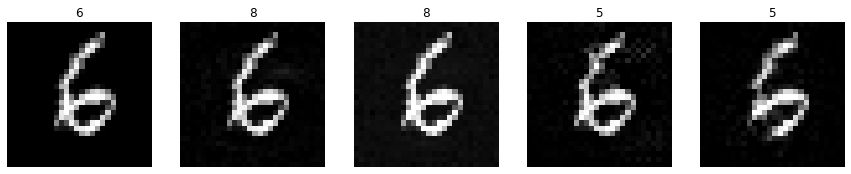

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt


for cnt,imset in enumerate(imgs):
  fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1,5)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  img1 = ax1.imshow(imset[4].reshape((28,28)), cmap = "gray")
  img2 = ax2.imshow(imset[0].reshape((28,28)), cmap = "gray")
  img3 = ax3.imshow(imset[1].reshape((28,28)), cmap = "gray")
  img4 = ax4.imshow(imset[2].reshape((28,28)), cmap = "gray")
  img5 = ax5.imshow(imset[3].reshape((28,28)), cmap = "gray")
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  if cnt == 0:
    ax1.set_title("Original: " + str(labs[cnt][-1]))
    ax2.set_title("Neural Net: " +  str(labs[cnt][0]))
    ax3.set_title("Noisy Neural Net: " +  str(labs[cnt][1]))
    ax4.set_title("ResNet: " + str(labs[cnt][2]))
    ax5.set_title("Noisy ResNet: "  + str(labs[cnt][3]))
  else:
    ax1.set_title(labs[cnt][-1])
    ax2.set_title(labs[cnt][0])
    ax3.set_title(labs[cnt][1])
    ax4.set_title(labs[cnt][2])
    ax5.set_title(labs[cnt][3])

In [69]:
diffs = [0,0,0,0,0]
deltaPix = [0,0,0,0,0]



for cnt,imset in enumerate(imgs):
  for cnt2, im in enumerate(imset):
    diffs[cnt2] += np.mean(imset[cnt2] - imset[-1])
    ds = imset[cnt2] - imset[-1]
    ds = ds.flatten()
    thresh = 25
    deltaPix[cnt2] += len(np.where(ds > thresh)[0])

In [70]:
[x/10 for x in diffs]

[20.573128253221512,
 30.263991928100587,
 3.6683082222938537,
 0.8146001905202865,
 0.0]

In [71]:
[x/10 for x in deltaPix]

[297.7, 487.2, 41.4, 39.3, 0.0]

In [ ]:
goods = []

for cnt in range(210):
  cands = [cnt]

  if len(goods) >= 100:
    break

  check = True

  for model in models:
    a = model.evaluate(X_test[cands],y_test[cands])
    if a[1] != 1:
      check = False
  
  #print(labels_mapping[y_test[num][0]])
  #plt.imshow(x_test[num])

  if check:
    goods.append(cnt)

In [ ]:
from copy import deepcopy
langs = list(range(0,10))
models = [classifier, noisy_classifier, ResNet, noisy_ResNet]

models_master_hist = []

for cnt10, model in enumerate(models):
  print("New Model")
  master_hist = []
  for i in goods:
    print(i)
    digit = X_test[i]
    label = test[1][i]
    y_true = np.zeros((1, 10))
    y_true[0, label] = 1
    digit = digit.astype("float32")
    #untargeted
    import numpy
    import keras
    digit2 = digit.reshape((1,28,28,1)).copy()
    true_target = y_true.copy()

    if cnt10 < 2:
      lr = 1
    else:
      lr = 1

    decay = 0.0005

    hist = [digit2]
    histp = [model.predict(digit2)]
    for t in range(1000):
      # gradient descent
      fake_img2 = digit2.reshape((1,28,28,1)).copy() # initialize
      fake_img = tf.Variable(fake_img2)

      with tf.GradientTape() as tape:
        tape.watch(fake_img)

        pred = model(fake_img)
        loss = keras.metrics.binary_crossentropy(pred, true_target)


      grad = tape.gradient(loss, fake_img)
      g = tf.sign(grad).numpy()
      #g = grad / np.max(numpy.abs(grad))
      g[g==0] = np.random.rand()
      g = np.nan_to_num(g, copy=True, nan = 1)
      #print(type(g))
      digits3 = digit2 + lr*g
      np.argmax(digits3)
      digit2 = digits3
      digit2[digit2 < 0] = 0
      digit2[digit2 > 255] = 255
      hist.append(digit2)
      histp.append(model.predict(digit2))

      lr = lr/(lr + decay*t)
      #print(lr)

      if np.argmax(pred.numpy()) != np.argmax(true_target) and np.max(pred.numpy()) > 0.9:
        print("Achieved at", t, loss.numpy())
        break
    master_hist.append([deepcopy(hist), deepcopy(histp)])
  models_master_hist.append(master_hist)
#plt.show()

In [ ]:
len(models_master_hist[0])

100

In [ ]:
imgs = []

for cnt in range(100):
  ims = [x[cnt][0][-1] for x in  models_master_hist]
  ims.append(models_master_hist[0][cnt][0][0])
  imgs.append(ims)

In [ ]:
diffs = [0,0,0,0,0]
deltaPix = [0,0,0,0,0]



for cnt,imset in enumerate(imgs):
  for cnt2, im in enumerate(imset):
    diffs[cnt2] += np.mean(imset[cnt2] - imset[-1])
    ds = imset[cnt2] - imset[-1]
    ds = ds.flatten()
    thresh = 25
    deltaPix[cnt2] += len(np.where(ds > thresh)[0])

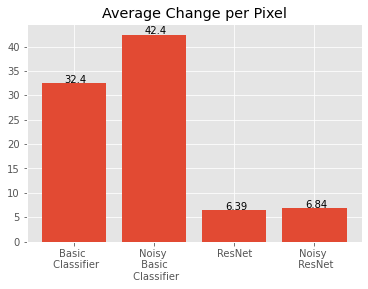

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

y = [x/100 for x in diffs][:-1]


plt.bar(["Basic \n Classifier", "Noisy \n Basic \n Classifier", "ResNet", "Noisy \n ResNet"],  y)

xlocs, xlabs = plt.xticks()

plt.title("Average Change per Pixel")

for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.12, v + 0.05, str(v)[:4])

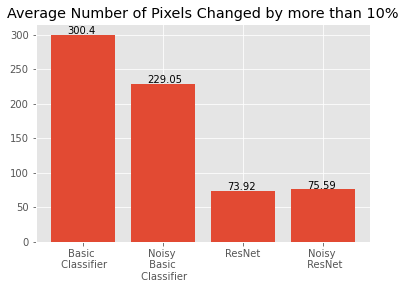

In [ ]:
y = [x/100 for x in deltaPix][:-1]
plt.bar(["Basic \n Classifier", "Noisy \n Basic \n Classifier", "ResNet", "Noisy \n ResNet"], y )

xlocs, xlabs = plt.xticks()

plt.title("Average Number of Pixels Changed by more than 10%")


for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.2, v + 0.5, str(v)[:6])

In [ ]:
diffs = [0,0,0,0,0]
deltaPix = [0,0,0,0,0]



for cnt,imset in enumerate(imgs):
  for cnt2, im in enumerate(imset):
    diffs[cnt2] += np.mean(imset[cnt2] - imset[-1])
    ds = imset[cnt2] - imset[-1]
    ds = ds.flatten()
    thresh = 0
    deltaPix[cnt2] += len(np.where(ds > thresh)[0])

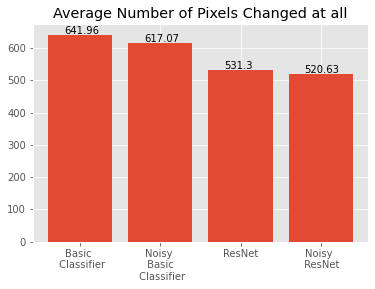

In [ ]:
y = [x/100 for x in deltaPix][:-1]
plt.bar(["Basic \n Classifier", "Noisy \n Basic \n Classifier", "ResNet", "Noisy \n ResNet"], y )

xlocs, xlabs = plt.xticks()

plt.title("Average Number of Pixels Changed at all")


for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.2, v + 3, str(v)[:6])

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(ResNet, show_shapes=True)